In [1]:
from datetime import date
import pandas as pd
import numpy as np
import statistics

from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")
df = df[['Date','2BRS_TIT_030A', '2BRS_TIT_030B','2BRS_PDIT_030','2BRS_FIT_030', '6BRS_PIT_015']]
df['Date']= pd.to_datetime(df['Date'])

salesprice = 10.5 #cent\kW
maintenancecost = 2000 #USD
#The main cost is the stopped production 
#to account for that, total $ value that could be earned will be calculated. 

#Some calculations
A1,B1,C1,dens = 1004.79,-0.0463,-0.0008,936.058
A,B,C,D,E,TC,LIQENT = 0.786889,-0.00187,4.163043,(-3.3*(10**(-7))),-0.0078,159,671.2794

df["T(F)"] = df["2BRS_TIT_030A"]*1.8 + 32 #convert from C to F
df["Flow(t/h)"] = df["2BRS_FIT_030"] * (A1 + B1*df["T(F)"] + C1*df["T(F)"]*df["T(F)"])/1000
df["Enthalpy_Entance (kj/kg)"] = (A + C*df["2BRS_TIT_030A"] + E*(df["2BRS_TIT_030A"]**2))/(1 + B*df["2BRS_TIT_030A"] + D*(df["2BRS_TIT_030A"]**2))
df["Enthalpy_Exit (kj/kg)"] = (A + C*df["2BRS_TIT_030B"] + E*(df["2BRS_TIT_030B"]**2))/(1 + B*df["2BRS_TIT_030B"] + D*(df["2BRS_TIT_030B"]**2))
df["MWE"] = 0.12*(df["Enthalpy_Entance (kj/kg)"] - df["Enthalpy_Exit (kj/kg)"]) * df["Flow(t/h)"] / 3600 #calculated, theoretical MWE
df["TempDiff"] = df["2BRS_TIT_030A"] - df["2BRS_TIT_030B"]

In [3]:
df= df.rename(columns={"2BRS_TIT_030A": "Entry temp (C)", 
                   "2BRS_TIT_030B": "Exit temp (C)",
                   "2BRS_PDIT_030": "Vap pres diff (bar)",
                   "2BRS_FIT_030": "Flowrate",
                   "6BRS_PIT_015": "Pump inj press",
                  })
df.head()

,Date,Entry temp (C),Exit temp (C),Vap pres diff (bar),Flowrate,Pump inj press,T(F),Flow(t/h),Enthalpy_Entance (kj/kg),Enthalpy_Exit (kj/kg),MWE,TempDiff
0,2018-04-25 01:00:00,105.72,99.46,1.5,1243.30,40.36,222.296,1187.308340,442.923394,416.509665,1.045375,6.26
1,2018-04-25 02:00:00,105.77,99.59,1.5,1253.11,40.36,222.386,1196.631207,443.134572,417.057688,1.040147,6.18
2,2018-04-25 03:00:00,105.70,99.48,1.5,1244.99,40.28,222.260,1188.940246,442.838923,416.593975,1.040123,6.22
3,2018-04-25 04:00:00,105.75,99.46,1.5,1245.53,40.27,222.350,1189.410873,443.050101,416.509665,1.052249,6.29
4,2018-04-25 05:00:00,105.82,99.48,1.5,1247.51,40.29,222.476,1191.238448,443.345754,416.593975,1.062258,6.34


In [4]:
def plotwithdates(df,start,end):
    #Sensor reads max 1.5 bar  
    #Pressure plot
    ax = df.plot.scatter(figsize = [12,5],x='Date',y='Vap pres diff (bar)',c='DarkBlue',label="Pressure")
    ax.set_ylabel("Pressure difference")
    ax.set_xlim([start,end])
    ax.grid()
    #Flowrate plot
    ax2 = df.plot.scatter(figsize = [12,5],x='Date',y='Flow(t/h)',c='green',label="Flowrate")
    ax2.set_xlim([start,end])
    ax2.grid()
    #MWE
    ax3 = df.plot.scatter(figsize = [12,5],x='Date',y='MWE',c='red',label="MWE")
    ax3.set_xlim([start,end])
    ax3.grid()
    #Temp diff
    ax4 = df.plot.scatter(figsize = [12,5],x='Date',y='TempDiff',c='blue',label="Temp Diff")
    ax4.set_xlim([start,end])
    ax4.set_ylim([0,20])
    ax4.grid()
    #Temp diff  
    ax5 = df.plot.scatter(figsize = [12,5],x='Date',y="Pump inj press",c='DarkBlue',label="Pressure")
    ax5.set_ylabel("Pump inj press")
    ax5.set_xlim([start,end])
    ax5.grid()
    

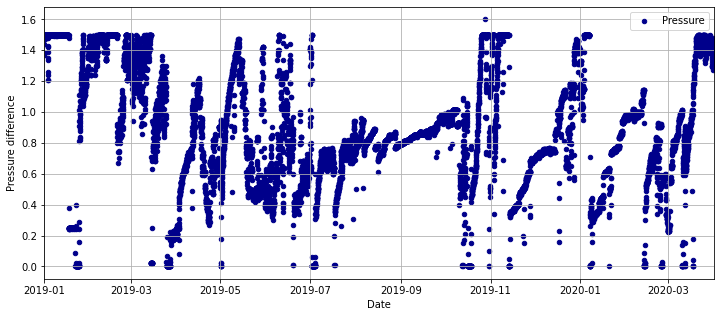

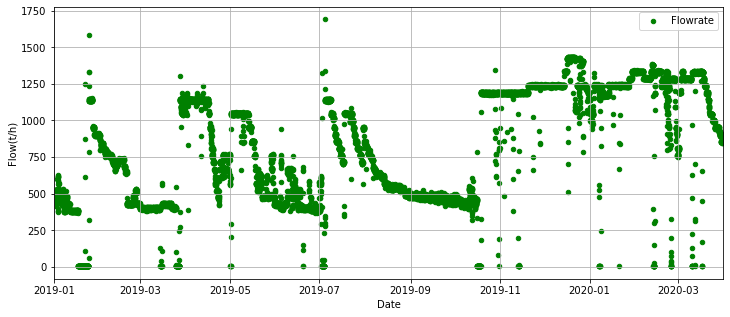

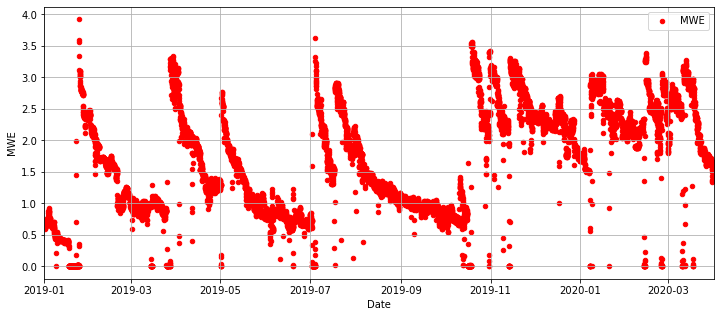

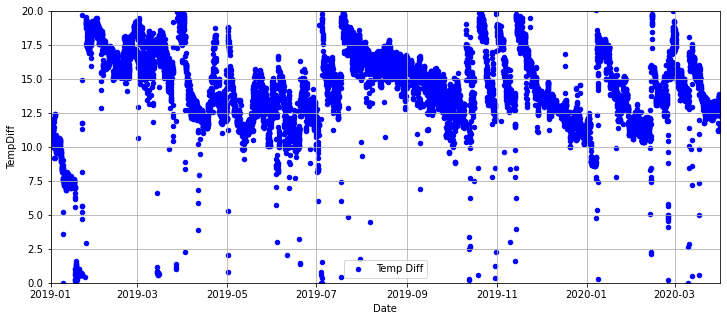

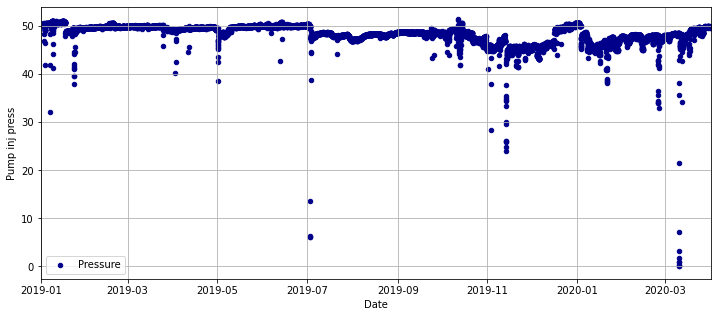

In [5]:
plotwithdates(df,start = date(2019,1,1),end = date(2020,4,1))

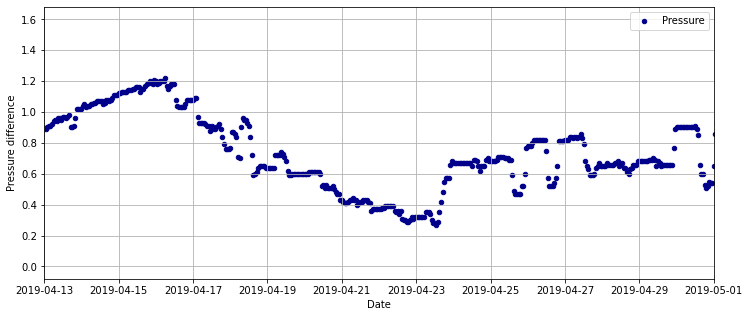

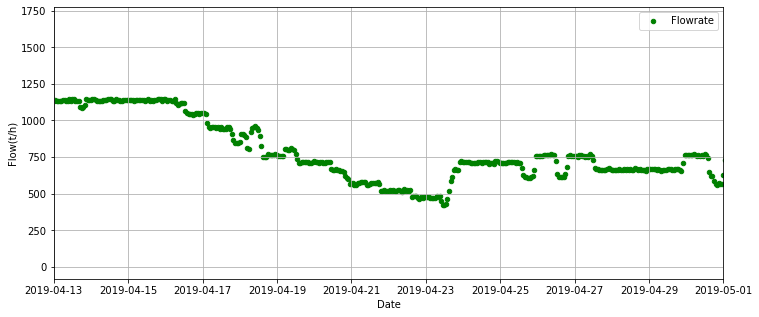

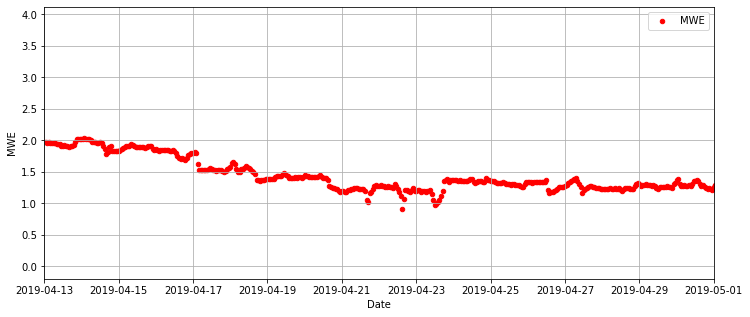

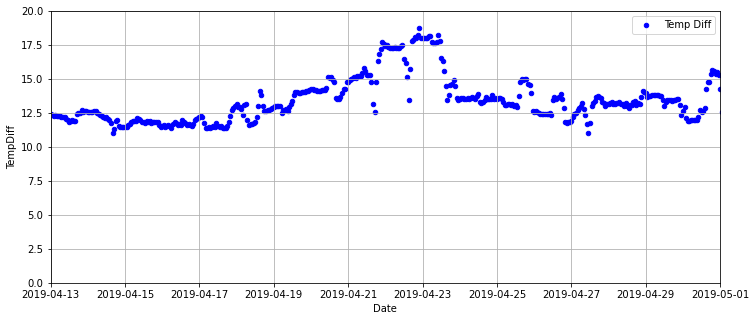

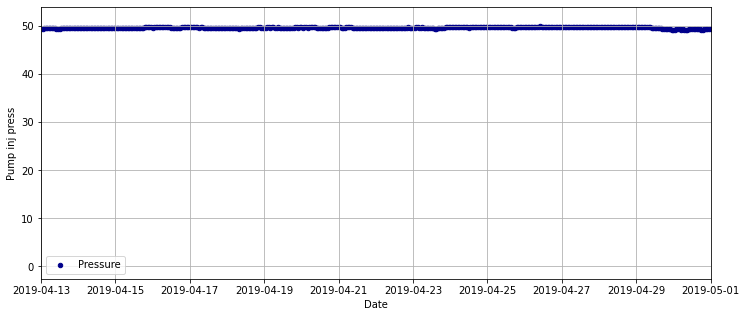

In [6]:
plotwithdates(df,start = date(2019,4,13),end = date(2019,5,1))

In [7]:
#For ML - only use the data with flow. 
df  = df[df["Flow(t/h)"] > 250]
df  = df[df["MWE"] > 0]
df  = df[df['Vap pres diff (bar)'] > 0]
df  = df[df['Vap pres diff (bar)'] < 1.4]

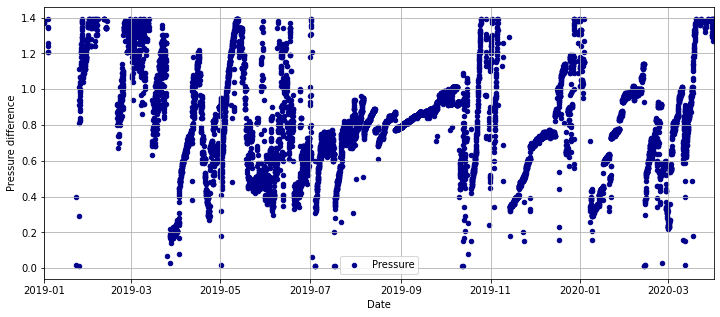

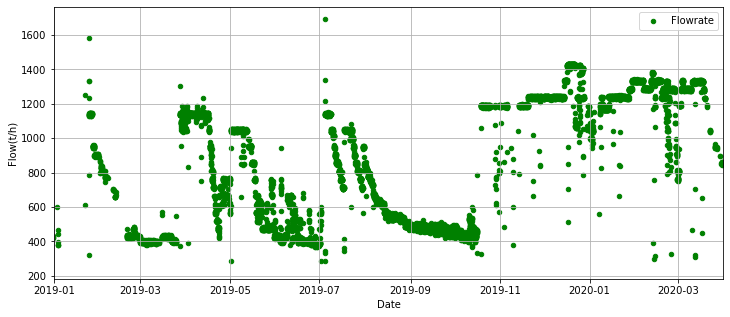

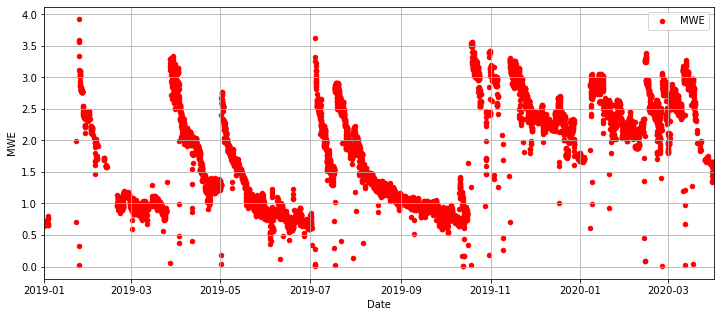

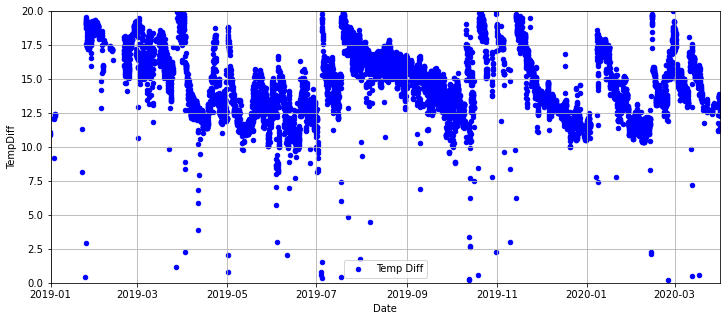

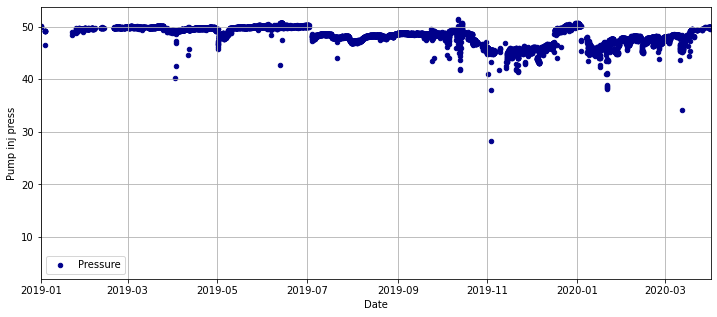

In [8]:
plotwithdates(df,start = date(2019,1,1),end = date(2020,4,1))

In [9]:
#Create the new hour feature for machine learning 
#the more we flow, the more pressures will increase

df['datediff'] = df['Date'].diff(1).astype('timedelta64[h]')
df = df.dropna()
datediff = df["datediff"].values
hour = np.zeros(len(datediff))

i = 0
while i< len(datediff):
    if i>0:
        if int(datediff[i]) == 1 or int(datediff[i]) == 0:
            hour[i] = hour[i-1] + 1
        elif int(datediff[i]) != 1 or nt(datediff[i]) != 0:
            hour[i] = 0
    i = i+1
    
df['hour'] = hour

<ipython-input-9-7bd3aa27c8de>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = hour


In [10]:
df.to_csv("analyzed.csv")

In [11]:
df.columns

Index(['Date', 'Entry temp (C)', 'Exit temp (C)', 'Vap pres diff (bar)',
       'Flowrate', 'Pump inj press', 'T(F)', 'Flow(t/h)',
       'Enthalpy_Entance (kj/kg)', 'Enthalpy_Exit (kj/kg)', 'MWE', 'TempDiff',
       'datediff', 'hour'],
      dtype='object')

In [12]:
#dfML_1 = df[['hour', 'TempDiff','Flow(t/h)','Pump inj press', 'Vap pres diff (bar)']]
dfML_2 = df[['Vap pres diff (bar)','Flow(t/h)', 'hour','MWE']]

dfML_1 = df[['hour', 'Flow(t/h)','Pump inj press','Vap pres diff (bar)']]
#dfML_2 = df[['Vap pres diff (bar)','Flow(t/h)', 'hour','TempDiff', 'MWE']]

In [13]:
dfML_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hour,11050.0,420.684977,561.730793,0.000000,45.000000,191.000000,532.000000,2403.000000
Flow(t/h),11050.0,820.418999,347.119862,254.712921,477.341615,755.773336,1184.442256,1691.167392
Pump inj press,11050.0,48.149534,2.282702,4.380000,47.650000,48.640000,49.630000,51.400000
Vap pres diff (bar),11050.0,0.839489,0.283890,0.010000,0.670000,0.830000,1.010000,1.390000


In [14]:
dfML_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Vap pres diff (bar),11050.0,0.839489,0.283890,0.010000,0.670000,0.830000,1.010000,1.390000
Flow(t/h),11050.0,820.418999,347.119862,254.712921,477.341615,755.773336,1184.442256,1691.167392
hour,11050.0,420.684977,561.730793,0.000000,45.000000,191.000000,532.000000,2403.000000
MWE,11050.0,1.648332,0.778306,0.000892,0.945611,1.419463,2.324578,3.920225


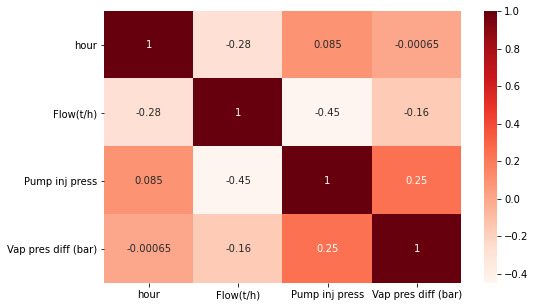

In [15]:
#Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
cor = dfML_1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

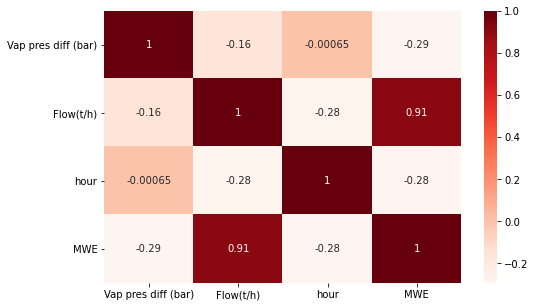

In [16]:
#Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
cor = dfML_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

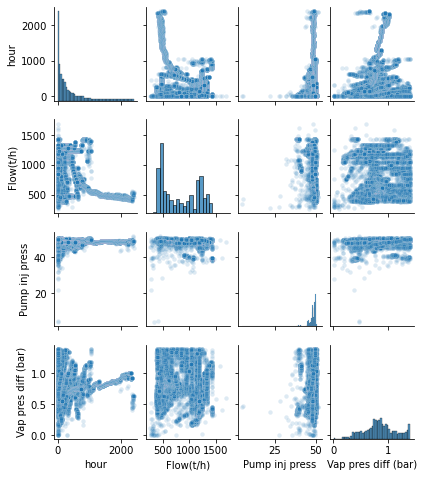

In [17]:
sns.pairplot(dfML_1.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

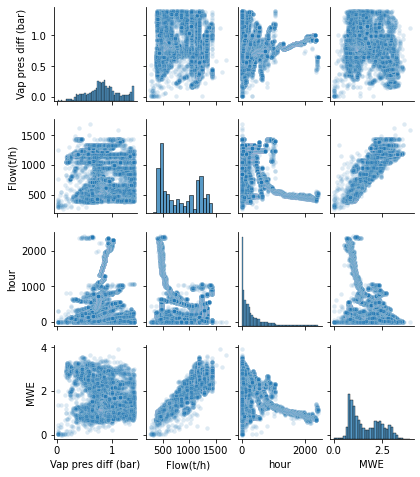

In [18]:
sns.pairplot(dfML_2.iloc[:,:], plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)

In [19]:
#Define the missing sklearn.metrics parameter of mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.abs((y_true - y_pred) / y_true)) * 100

def r_score(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    residuals = y_true- y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true-np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)    
    return r_squared

In [20]:
def MLmodels(data=dfML_1,tuning=False):
    n = len(data.columns)
    X = data.iloc[:,0:n-1].to_numpy()
    y = data.iloc[:,n-1].to_numpy()

    X_train, X_test, y_train, y_test= train_test_split(X,y,test_size = 0.20)

    #Inputs------------------------------------------------------------------------
    #Enter tuning=True if tuning required
    randomforestparametertuning = tuning
    XGboostparametertuning      = tuning
    SVMparametertuning          = tuning
    MLPparametertuning          = tuning
    
    if randomforestparametertuning:
        print ("Performing gridsearch in random forest")

        # Create the parameter grid based on the results of random search 
        param_grid = {
            'bootstrap': [True,False],
            'max_depth': [40, 50, 60, 70],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1,2,3,],
            'min_samples_split': [3, 4, 5,6,7],
            'n_estimators': [50,100,150,200,250,300,350,400,500]
            }

        # Create a based model
        rf = RandomForestRegressor()
        # Instantiate the grid search model
        grid_search_RF = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                  cv = 3, n_jobs = -1, verbose = 2)

        # Fit the grid search to the data
        grid_search_RF.fit(X_train2, y_train2)
        print("Grid Search Best Parameters for Random Forest Regression")
        print (grid_search_RF.best_params_)
    #XGBoost Parameter Tuning------------------------------------------------------

    if XGboostparametertuning:
        print("XGBoost parameter tuning")
        # Create the parameter grid based on the results of random search 
        grid = {'colsample_bytree': [0.9,0.8,0.7],
                        'gamma': [2,3,4,5],
                        'learning_rate': [0.1,0.2,0.3],
                        'max_depth': [8,9,10,11,12],
                        'n_estimators': [150,200,250,300,350],
                        'subsample': [0.8,0.9,1],
                        'reg_alpha': [15,18,20],
                        'min_child_weight':[3,4,5]}

        # Create a based model
        XGB = XGBRegressor()
        # Instantiate the grid search model
        grid_search_XGB = GridSearchCV(estimator = XGB, param_grid = grid, 
                                  cv = 3, n_jobs = -1, verbose = 2)

        # Fit the grid search to the data
        grid_search_XGB.fit(X_train2, y_train2)
        print("Grid Search Best Parameters for XGBoost")
        print (grid_search_XGB.best_params_) 
        
    #SVM Parameter Tuning----------------------------------------------------------
    if SVMparametertuning:
        print("SVM parameter tuning")

        C_range = 10. ** np.arange(-3, 3)
        gamma_range = 10. ** np.arange(-5, 3)
        param_grid = dict(gamma=gamma_range, C=C_range)
        svr_rbf = SVR()
        # Instantiate the grid search model
        grid_search_svm = GridSearchCV(estimator = svr_rbf, param_grid = param_grid, 
                                  cv = 3, n_jobs = -1, verbose = 2)
        # Fit the grid search to the data
        grid_search_svm.fit(X_train2, y_train2)
        print("Grid Search Best Parameters for SVM")
        print (grid_search_svm.best_params_)

        if MLPparametertuning:
            print("MLP parameter tuning")

            param_grid = {
                'hidden_layer_sizes': [50,100,150,200,250,300,350],
                'activation': ['identity','logistic','tanh','relu'],
                'solver': ['lbfgs', 'sgd','adam'],
                'learning_rate': ['constant','invscaling','adaptive']}
            MLP = MLPRegressor()
            # Instantiate the grid search model
            grid_search_MLP = GridSearchCV(estimator = MLP, param_grid = param_grid, 
                                      cv = 3, n_jobs = -1, verbose = 2)

            # Fit the grid search to the data
            grid_search_MLP.fit(X_train2, y_train2)
            print("Grid Search Best Parameters for MLP")
            print (grid_search_MLP.best_params_)

        #Fitting multi linear regression to data---------------------------------------
    print ("Fit multilinear regression")
    linreg = LinearRegression()
    linreg.fit(X_train,y_train)

    #Fitting ridge regression to data----------------------------------------------
    print ("Fit ridge regression")
    ridgeReg = Ridge(alpha=0.05, normalize=True)
    ridgeReg.fit(X_train,y_train)

    #Fitting random forest regression to data--------------------------------------
    print ("Fit random forest regression")
    try:
        randreg = RandomForestRegressor(**grid_search_RF.best_params_)
    except:
        randreg = RandomForestRegressor()
    randreg.fit(X_train,y_train)

    #Fitting LASSO regression to data----------------------------------------------
    print ("Fit Lasso regression")
    lassoreg = Lasso(alpha=0.01, max_iter=10e5)
    lassoreg.fit(X_train, y_train)

    #Support Vector Machines-------------------------------------------------------
    print ("Fit SVR RBF regression")
    try:
        svr_rbf = SVR(**grid_search_svm.best_params_)
    except:
        svr_rbf = SVR()
        svr_rbf.fit(X_train, y_train)

    #MLP Regressor-----------------------------------------------------------------
    print ("Fit Multi-layer Perceptron regressor")
    try:
        MLP = MLPRegressor(**grid_search_MLP.best_params_)
    except:
        MLP = MLPRegressor()    
    MLP.fit(X_train, y_train)

    y_predicted_RF = randreg.predict(X_test)
    y_predicted_LREG = linreg.predict(X_test)
    y_predicted_RIDGE = ridgeReg.predict(X_test)
    y_predicted_LASSO = lassoreg.predict(X_test)
    y_predicted_svr_rbf = svr_rbf.predict(X_test)
    y_predicted_MLP = MLP.predict(X_test)

    r_RF=  r_score(y_test, y_predicted_RF)
    MAE_RF = mean_absolute_error(y_test, y_predicted_RF)
    MSE_RF = mean_squared_error(y_test, y_predicted_RF)
    MAPE_RF = mean_absolute_percentage_error(y_test, y_predicted_RF)

    r_LREG=  r_score(y_test, y_predicted_LREG)
    MAE_LREG = mean_absolute_error(y_test, y_predicted_LREG)
    MSE_LREG = mean_squared_error(y_test, y_predicted_LREG)
    MAPE_LREG = mean_absolute_percentage_error(y_test, y_predicted_LREG)

    r_RIDGE=  r_score(y_test, y_predicted_RIDGE)
    MAE_RIDGE = mean_absolute_error(y_test, y_predicted_RIDGE)
    MSE_RIDGE = mean_squared_error(y_test, y_predicted_RIDGE)
    MAPE_RIDGE = mean_absolute_percentage_error(y_test, y_predicted_RIDGE)

    r_LASSO=  r_score(y_test, y_predicted_LASSO)
    MAE_LASSO = mean_absolute_error(y_test, y_predicted_LASSO)
    MSE_LASSO = mean_squared_error(y_test, y_predicted_LASSO)
    MAPE_LASSO = mean_absolute_percentage_error(y_test, y_predicted_LASSO)

    r_svr_rbf=  r_score(y_test, y_predicted_svr_rbf)
    MAE_svr_rbf = mean_absolute_error(y_test, y_predicted_svr_rbf)
    MSE_svr_rbf = mean_squared_error(y_test, y_predicted_svr_rbf)
    MAPE_svr_rbf = mean_absolute_percentage_error(y_test, y_predicted_svr_rbf)

    r_MLP=  r_score(y_test, y_predicted_MLP)
    MAE_MLP = mean_absolute_error(y_test, y_predicted_MLP)
    MSE_MLP = mean_squared_error(y_test, y_predicted_MLP)
    MAPE_MLP = mean_absolute_percentage_error(y_test, y_predicted_MLP)

    errors = [{'Model Name': 'Random Forest Regression', 'R2': r_RF, 'MAE': MAE_RF, 'MSE': MSE_RF, 'MAPE (%)': np.mean(MAPE_RF), 'Median Error (%)': statistics.median(MAPE_RF)},
              {'Model Name': 'Linear Regression', 'R2': r_LREG, 'MAE': MAE_LREG, 'MSE': MSE_LREG, 'MAPE (%)': np.mean(MAPE_LREG), 'Median Error (%)': statistics.median(MAPE_LREG)},
              {'Model Name': 'Ridge Regression', 'R2': r_RIDGE, 'MAE': MAE_RIDGE, 'MSE': MSE_RIDGE, 'MAPE (%)': np.mean(MAPE_RIDGE), 'Median Error (%)': statistics.median(MAPE_RIDGE)},
              {'Model Name': 'Lasso Regression', 'R2': r_LASSO, 'MAE': MAE_LASSO, 'MSE': MSE_LASSO, 'MAPE (%)': np.mean(MAPE_LASSO), 'Median Error (%)': statistics.median(MAPE_LASSO)},
              {'Model Name': 'Support Vector Machine', 'R2': r_svr_rbf, 'MAE': MAE_svr_rbf, 'MSE': MSE_svr_rbf, 'MAPE (%)': np.mean(MAPE_svr_rbf), 'Median Error (%)': statistics.median(MAPE_svr_rbf)},
              {'Model Name': 'Multi-layer Perceptron', 'R2': r_MLP, 'MAE': MAE_MLP, 'MSE': MSE_MLP, 'MAPE (%)': np.mean(MAPE_MLP), 'Median Error (%)': statistics.median(MAPE_MLP)}]

    df_estimationerrors = pd.DataFrame(errors)
    df_estimationerrors= df_estimationerrors.sort_values(by=['Median Error (%)'])
    print(df_estimationerrors)
    
    #Principal Component Analysis
    features = data.columns[:-1]
    importances = randreg.feature_importances_
    indices = np.argsort(importances)
    plt.figure(3) #the axis number
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    #plt.savefig('Feature Importance.png', 
    #              bbox_inches='tight', dpi = 500)

    #df_estimationerrors.to_csv("errors.csv")
    return randreg, plt, df_estimationerrors

Fit multilinear regression
Fit ridge regression
Fit random forest regression
Fit Lasso regression
Fit SVR RBF regression
Fit Multi-layer Perceptron regressor
                 Model Name        R2       MAE       MSE   MAPE (%)  \
0  Random Forest Regression  0.836852  0.047144  0.013043   8.905050   
4    Support Vector Machine  0.294590  0.173359  0.056396  33.889794   
1         Linear Regression  0.064669  0.212003  0.074778  40.493346   
2          Ridge Regression  0.065264  0.212123  0.074730  40.519860   
3          Lasso Regression  0.066091  0.212189  0.074664  40.566491   
5    Multi-layer Perceptron -0.076031  0.235531  0.086027  46.795453   

   Median Error (%)  
0          1.403390  
4         13.534446  
1         19.779532  
2         19.824824  
3         19.829011  
5         22.387066  


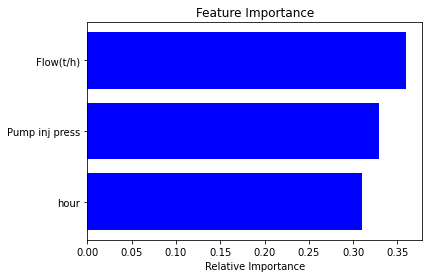

In [21]:
randreg1, plt1, df_estimationerrors1 = MLmodels(data=dfML_1,tuning=False)

Fit multilinear regression
Fit ridge regression
Fit random forest regression
Fit Lasso regression
Fit SVR RBF regression
Fit Multi-layer Perceptron regressor
                 Model Name        R2       MAE       MSE   MAPE (%)  \
0  Random Forest Regression  0.976744  0.052732  0.014101   6.299020   
4    Support Vector Machine  0.873333  0.191399  0.076803  27.231629   
5    Multi-layer Perceptron  0.831612  0.229139  0.102100  26.654343   
2          Ridge Regression  0.843360  0.237910  0.094977  35.835464   
1         Linear Regression  0.845498  0.237945  0.093680  34.467646   
3          Lasso Regression  0.842363  0.238150  0.095581  32.025898   

   Median Error (%)  
0          1.426943  
4          8.817359  
5         10.717164  
2         13.677266  
1         13.850276  
3         13.885688  


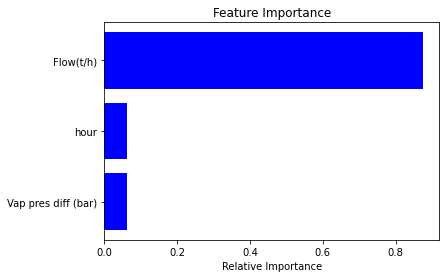

In [22]:
randreg2, plt2, df_estimationerrors2 = MLmodels(data=dfML_2,tuning=False)

Now there are two models:

First one predicts "Vap pres diff (bar)", 

using "hour, TempDiff, Flow(t/h), Pump inj press"

Second one predicts "MWE", 

using "Vap pres diff (bar), Flow(t/h), hour, TempDiff"

Default values for following analysis:
Pump inj press = 50
TempDiff = 15

In [23]:
df = pd.DataFrame({'hour': np.arange(1000)})
df['Flow(t/h)'] = 1000
df['Pump inj press'] = 50

#dfML_1 = df[['hour', 'Flow(t/h)','Pump inj press','Vap pres diff (bar)']]
#dfML_2 = df[['Vap pres diff (bar)','Flow(t/h)', 'hour','MWE']]

df

,hour,Flow(t/h),Pump inj press
0,0,1000,50
1,1,1000,50
2,2,1000,50
3,3,1000,50
4,4,1000,50
...,...,...,...
995,995,1000,50
996,996,1000,50
997,997,1000,50
998,998,1000,50


In [24]:
df_new = pd.DataFrame()
df_new["Vap pres diff (bar)_predicted"] = randreg1.predict(df.to_numpy())

df_new['Flow(t/h)'] = df['Flow(t/h)']
df_new['hour'] = df['hour']

df_new['MWE_predicted'] = randreg2.predict(df_new.to_numpy())

In [25]:
df_new

,Vap pres diff (bar)_predicted,Flow(t/h),hour,MWE_predicted
0,1.3000,1000,0,1.217979
1,1.2403,1000,1,0.958473
2,1.2263,1000,2,1.180998
3,1.1828,1000,3,1.393382
4,1.1760,1000,4,1.430150
...,...,...,...,...
995,0.6654,1000,995,2.029298
996,0.6654,1000,996,2.029298
997,0.6654,1000,997,2.029298
998,0.6654,1000,998,2.030363


In [26]:
df_new.sum(axis = 0, skipna = True)

Vap pres diff (bar)_predicted        899.932200
Flow(t/h)                        1000000.000000
hour                              499500.000000
MWE_predicted                       1905.639277
dtype: float64

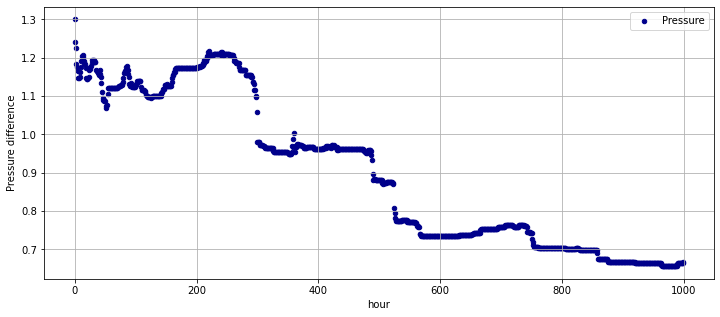

In [27]:
ax = df_new.plot.scatter(figsize = [12,5],x='hour',y='Vap pres diff (bar)_predicted',c='DarkBlue',label="Pressure")
ax.set_ylabel("Pressure difference")
ax.grid()

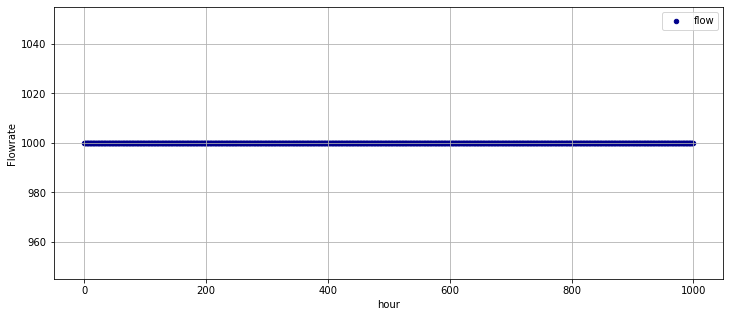

In [28]:
ax2 = df_new.plot.scatter(figsize = [12,5],x='hour',y='Flow(t/h)',c='DarkBlue',label="flow")
ax2.set_ylabel("Flowrate")
ax2.grid()

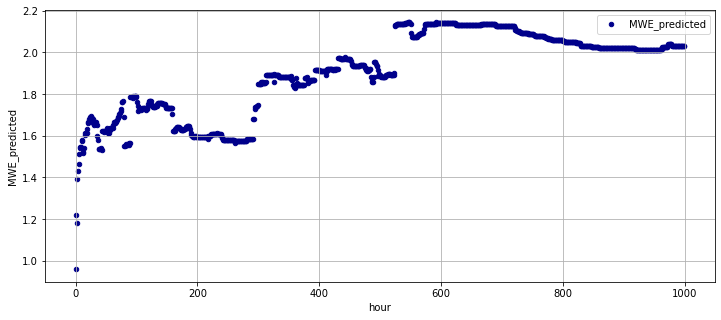

In [29]:
ax3 = df_new.plot.scatter(figsize = [12,5],x='hour',y='MWE_predicted',c='DarkBlue',label="MWE_predicted")
ax3.grid()